In [1]:
from file_storage import FileStorage

In [2]:
from urllib.parse import urlparse
from urllib.parse import urldefrag

from urllib.parse import urljoin
from urllib.request import urlopen

In [60]:
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import numpy as np
import collections
import csv
import matplotlib.pyplot as plt
import random

In [4]:
def extract_links_from_html(url, html):
    parser = BeautifulSoup(html, 'lxml')
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]

In [5]:
cleared = FileStorage('cleared')

In [6]:
vertexes = {}

for i, key in enumerate(cleared.keys()):
    vertexes.update({key: i})

In [7]:
keys = set(cleared.keys())

In [8]:
#составим граф
G = []
for key in tqdm(keys):
    html = cleared.read(key)
    links = extract_links_from_html(key, html)
    
    tmp = []
    for url in links:
        url = urldefrag(url).url
        if url in keys:
            tmp.append(vertexes[url])
    
    G.append(tmp)

 61%|██████▏   | 106249/173451 [46:54<36:01, 31.09it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 143570/173451 [1:06:04<14:44, 33.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 173451/173451 [1:21:28<00:00, 35.48it/s]


In [15]:
#считаем PageRank
PR = {}
with open('doc_list.csv', 'r', newline='\n') as f_r:
    reader = csv.reader(f_r, delimiter=',')
    
    for line in reader:
        PR.update({vertexes[line[0]]: float(line[1])})

## Сверх читерная##

In [85]:
WC_1 = np.cumsum(np.array(sorted(PR.values(), reverse=True)))

## Читерная

In [113]:
WC_2 = []

start = 'https://simple.wikipedia.org/wiki/Main_Page'

color = {val:False for val in vertexes.values()}

queue = [vertexes[start]]

while(sum(color.values()) < len(G)):
    if len(queue) == 0:
        tmp = np.argmin(list(color.values()))
        queue.append(tmp)
        
    while(len(queue) > 0):
        cur = queue.pop()

        if not color[cur]:
            WC_2.append(PR[cur])
            color[cur] = True

            sons = sorted([[el, PR[el]] for el in G[cur]], key=lambda x: x[1])
            queue.extend([son[0] for son in sons])
        
WC_2 = np.cumsum(WC_2)

## Обход в ширину

In [107]:
WC_3 = []

color = {val:False for val in vertexes.values()}
color[vertexes[start]] = True

deque = collections.deque()
deque.append(vertexes[start])

while(sum(color.values()) < len(G)):
    if len(deque) == 0:
        tmp = np.argmin(list(color.values()))
        deque.append(tmp)
        color[tmp] = True
    
    while(len(deque) > 0):
        cur = deque.popleft()
        WC_3.append(PR[cur])

        for v in G[cur]:
            if not color[v]:
                color[v] = True
                deque.append(v)

WC_3 = np.cumsum(WC_3)

##  Выбор случайного урла из очереди

In [114]:
WC_4 = []

color = {val:False for val in vertexes.values()}

queue = [vertexes[start]]

while(sum(color.values()) < len(G)):
    if len(queue) == 0:
        tmp = np.argmin(list(color.values()))
        queue.append(tmp)

    while(len(queue) > 0):
        cur = queue.pop()

        if not color[cur]:
            WC_4.append(PR[cur])
            color[cur] = True

            sons = np.copy(G[cur])
            random.shuffle(sons)
            queue.extend(sons)
        
WC_4 = np.cumsum(WC_4)

## Приоритезация по количеству входящих ссылок

In [117]:
WC_5 = []

link_in = np.zeros(len(G))
link_in[vertexes[start]] = 1

while(np.sum(link_in) > -len(link_in)):
    cur = np.argmax(link_in)
    WC_5.append(PR[cur])
    link_in[cur] = -1
    
    for v in G[cur]:
        if link_in[v] > -1:
            link_in[v] += 1

WC_5 = np.cumsum(WC_5)

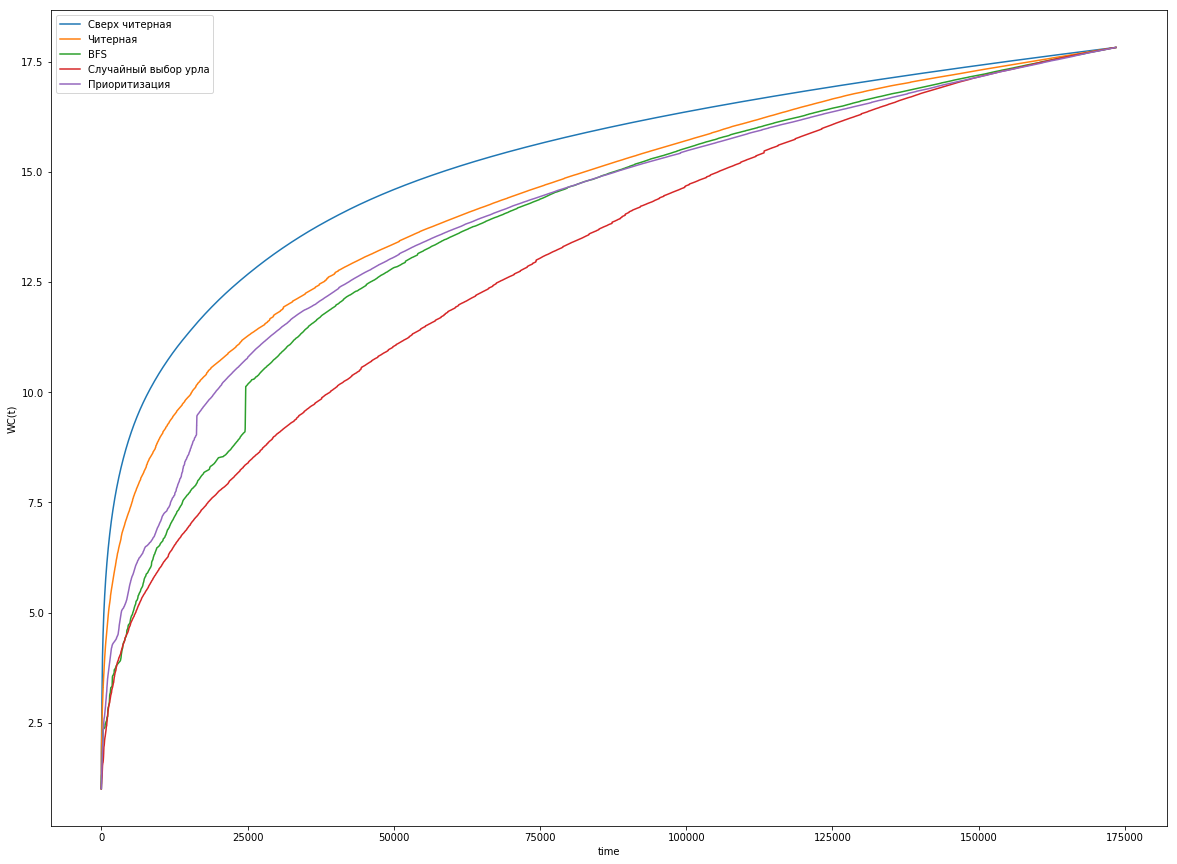

In [122]:
plt.figure(figsize=(20, 15))
x = range(len(G))
plt.plot(x, WC_1, label='Сверх читерная')
plt.plot(x, WC_2, label='Читерная')
plt.plot(x, WC_3, label='BFS')
plt.plot(x, WC_4, label='Случайный выбор урла')
plt.plot(x, WC_5, label='Приоритизация')
plt.xlabel('time')
plt.ylabel('WC(t)')
plt.legend()
plt.show()